## just gmm stuff

In [1]:
# IMPORT LIBRARIES AND QUICK INFO, IMPLEMENTATION OF FUNCTIONS

# stole some code from notebook L07
# import stuff

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import rand_score, adjusted_rand_score
from scipy import stats

def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

'''
quick notes for future me

the labels are broken up into 0-25, one for each letter of the alphabet

training data has 27,455 cases, test data has 7,172 cases

'''


'\nquick notes for future me\n\nthe labels are broken up into 0-25, one for each letter of the alphabet\n\ntraining data has 27,455 cases, test data has 7,172 cases\n\n'

In [2]:
# ESTABLISH DATA
# after some consideration, since we're doing GMM, just use train_data (single set of data)
# later on, considered this predict_data
# let's try running everything on true_data as well

test_data = pd.read_csv("data/sign_mnist_test.csv")
true_labels = test_data['label']

print(f"test_data.shape is {test_data.shape}")
print(f"true_labels.shape is {true_labels.shape}")

test_data.shape is (7172, 785)
true_labels.shape is (7172,)


In [3]:
# make predict_data and scaled predict data
predict_data = test_data.drop(['label'], axis=1) # well, most of the time, we're just going to use predict_data for fitting/metrics
# let's scale the data !!
scaler = StandardScaler()

scaled_predict_data = scaler.fit_transform(predict_data)

In [4]:
# fit data
gmm = GaussianMixture(n_components=5, random_state=42)
gmm_scaled = GaussianMixture(n_components=5, random_state=42)

gmm.fit(predict_data)
gmm_scaled.fit(scaled_predict_data)

GaussianMixture(n_components=5, random_state=42)

In [5]:
print(f"scaled_predict_data.shape is {scaled_predict_data.shape}")

scaled_predict_data.shape is (7172, 784)


In [6]:
# make prediction of data on predict_data
non_scaled_predicted = gmm.predict(predict_data)
scaled_predicted = gmm_scaled.predict(scaled_predict_data)

In [7]:
acc_nonscaled = accuracy_score(true_labels, non_scaled_predicted)
acc_scaled = accuracy_score(true_labels, scaled_predicted)

print(f"acc_nonscaled is {acc_nonscaled}")
print(f"acc_scaled is {acc_scaled}")

acc_nonscaled is 0.06134969325153374
acc_scaled is 0.03973786949247072


In [8]:
# calculate adjusted/non-adjusted rand index, silhouette coefficient, BIC, AIC
# NON-SCALED
adjusted_rand_nonscaled = adjusted_rand_score(true_labels, non_scaled_predicted)
non_adjusted_rand_nonscaled = rand_score(true_labels, non_scaled_predicted)

# SCALED
adjusted_rand_scaled = adjusted_rand_score(true_labels, scaled_predicted)
non_adjusted_rand_scaled = rand_score(true_labels, scaled_predicted)

# NON-SCALED
print("Non-scaled Adjusted Rand Score:", adjusted_rand_nonscaled)
print("Non-scaled Non-Adjusted Rand Score:", non_adjusted_rand_nonscaled)

# SCALED
print("Scaled Adjusted Rand Score:", adjusted_rand_scaled)
print("Scaled Non-Adjusted Rand Score:", non_adjusted_rand_scaled)

Non-scaled Adjusted Rand Score: 0.03186812542464929
Non-scaled Non-Adjusted Rand Score: 0.7563367759916059
Scaled Adjusted Rand Score: 0.02655850177293507
Scaled Non-Adjusted Rand Score: 0.7534550957904051


To preface, I did things in a bit of a backwards fashion: I manually ran adjusted and non_adjusted rand score multiple times   with different numbers of components (5, 10, 15 for example) and just kept getting terrible Adjusted Rand Scores. Therefore, I plotted out AIC/BIC/Silhouette Scores at the end, rather than toward the beginning. More on that later.


With regards to using 5 components, our non-adjusted Rand Score looks great for GMM, the Adjusted Rand Score is, frankly, atrocious. Considering that our ARI is near 0, the labeling may as well be random. 

In [9]:
# calculate BIC
bic = gmm.bic(predict_data) # i'm too lazy to import it directly
print(f"bic is {bic}")

scaled_bic = gmm_scaled.bic(scaled_predict_data)
print(f"scaled_bic is {scaled_bic}")

bic is 29960126.324507114
scaled_bic is -12621242.066509252


As a quick recap, let's recall the BIC and AIC formulas: AIC is equal to $2k - 2\ln(L)$ while BIC is equal to $k \ln (n) - 2 \ln (L)$. As can be seen, BIC takes into account how many data points/observations one is using, in the form of $n$. Both, however, follow the same rule of lower being better.

Regarding our BIC value, it appears to be extremely high, being nine digits long. As such, we can come to the conclusion that the there are far higher penalty terms, and that the current GMM doesn't fit the original data all too well.

As was touched upon earlier, this doesn't seem to be a one-off: with GMMs with different numbers of components, BIC scores were still, frankly, quite terrible with varying numbers of components.

In [10]:
# calculate AIC 
aic = gmm.aic(predict_data) # i'm too lazy to import it directly
print(f"aic is {aic}")

scaled_aic = gmm_scaled.aic(scaled_predict_data)
print(f"scaled_aic is {scaled_aic}")

aic is 19350739.058887735
scaled_aic is -23230629.332128633


Our AIC score was also quite bad, coming in at nine digits long. To reiterate, GMM may not be the best model for our set of sign language/MNIST drop-in data.

In [11]:
# calculate silhouette coefficient

# gonna be non-predicted data, then predicted data
silhouette_nonscaled = silhouette_score(predict_data, non_scaled_predicted)
print(f"silhouette_nonscaled is {silhouette_nonscaled}")

silhouette_scaled = silhouette_score(scaled_predict_data, scaled_predicted)
print(f"silhouette_scaled is {silhouette_scaled}")

silhouette_nonscaled is 0.05832277158966777
silhouette_scaled is 0.05948531487712677


In [12]:
# calculate log likelihood of each sample in the GMM for nonscaled and scaled
nonscaled_score_samples = gmm.score_samples(predict_data)
print(f"nonscaled_score_samples is {nonscaled_score_samples}")

scaled_score_samples = gmm_scaled.score_samples(scaled_predict_data)
print(f"scaled_score_samples is {scaled_score_samples}")


nonscaled_score_samples is [ -973.57574766 -1104.58404237 -1436.9289792  ... -1563.02697731
 -1552.30550087 -1154.78214765]
scaled_score_samples is [1789.08036298 1740.26117114 2164.23790377 ... 1358.652751   1419.73679264
 1813.76991808]


Our silhouette score was also low, unsurprisingly. As with what we saw with AIC, BIC, Rand Score, and Adjusted Rand Score, GMM, once again is probably not ideal for this dataset.

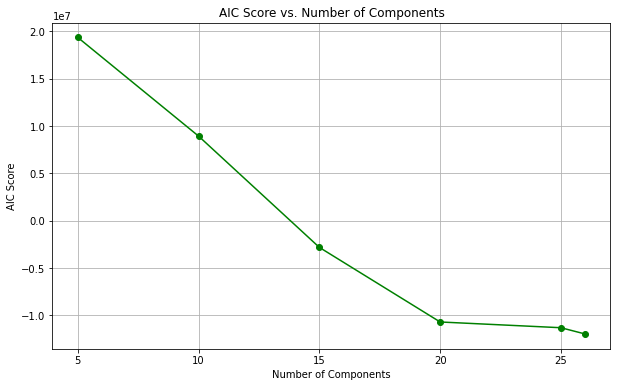

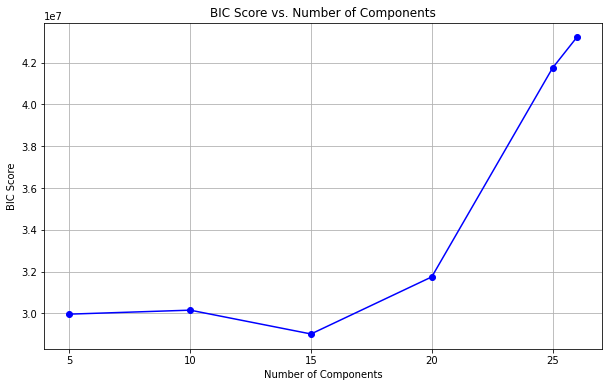

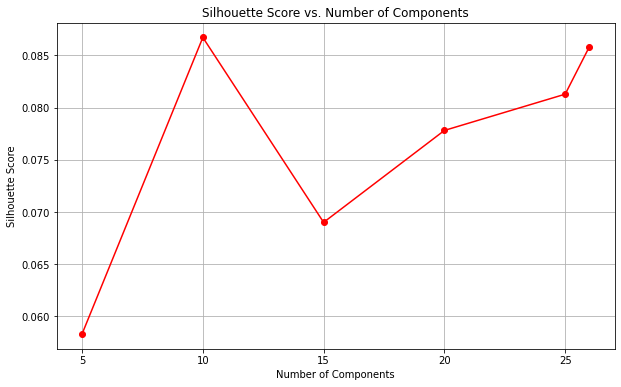

In [13]:
# run AIC, BIC, Silhouette for Non_Scaled

# store aic, bic, silhouette scores
aic_scores = []
bic_scores = []
silhouette_scores = []
components_range = [5, 10, 15, 20, 25, 26]  # Range of components to try

# # run bic and silhouette for each one
for n_components in components_range:
    # re-do gmm
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    
    # fit
    gmm.fit(predict_data)
    
    # AIC score
    aic = gmm.aic(predict_data)
    aic_scores.append(aic) 
    
    # BIC score
    bic = gmm.bic(predict_data)
    bic_scores.append(bic)
    
    # silhouette score 
    silhouette = silhouette_score(predict_data, gmm.predict(predict_data))
    silhouette_scores.append(silhouette)

# plot aic
plt.figure(figsize=(10, 6))
plt.plot(components_range, aic_scores, marker='o', linestyle='-', color='g')
plt.xlabel('Number of Components')
plt.ylabel('AIC Score')
plt.title('AIC Score vs. Number of Components')
plt.grid(True)
plt.show()
    
# plot bic
plt.figure(figsize=(10, 6))
plt.plot(components_range, bic_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.title('BIC Score vs. Number of Components')
plt.grid(True)
plt.show()

# plot silhouette
plt.figure(figsize=(10, 6))
plt.plot(components_range, silhouette_scores, marker='o', linestyle='-', color='r')
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Components')
plt.grid(True)
plt.show()


One question we wanted to address off the bat was: why not plot Rand/Adjusted Rand Score as well? This code block takes a while to run, 

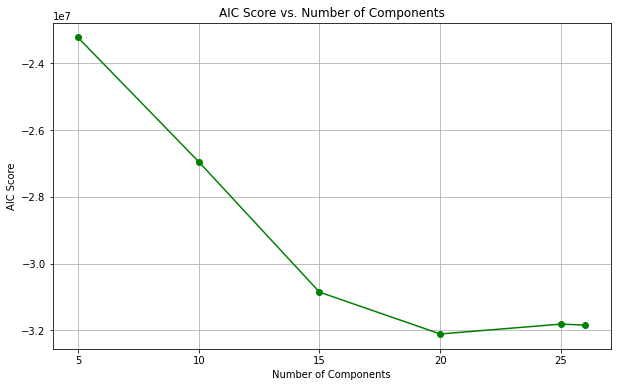

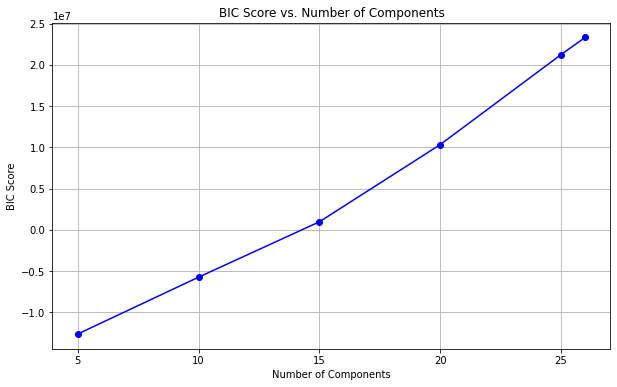

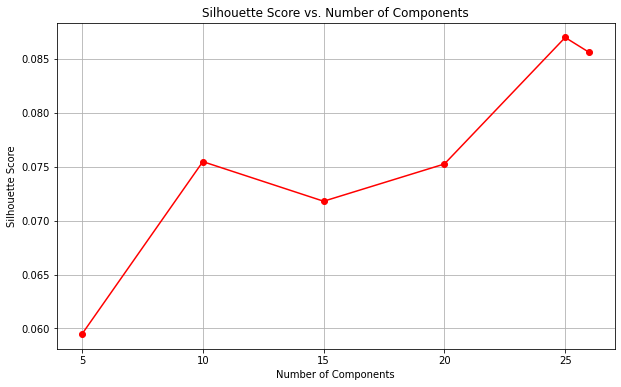

In [14]:
# run AIC, BIC, Silhouette for Scaled

# store aic, bic, silhouette scores
aic_scores = []
bic_scores = []
silhouette_scores = []
components_range = [5, 10, 15, 20, 25, 26]  # Range of components to try

# # run bic and silhouette for each one
for n_components in components_range:
    # re-do gmm_scaled
    gmm_scaled = GaussianMixture(n_components=n_components, random_state=42)
    
    # fit
    gmm_scaled.fit(scaled_predict_data)
    
    # AIC score
    aic = gmm_scaled.aic(scaled_predict_data)
    aic_scores.append(aic) 
    
    # BIC score
    bic = gmm_scaled.bic(scaled_predict_data)
    bic_scores.append(bic)
    
    # silhouette score 
    silhouette = silhouette_score(scaled_predict_data, gmm_scaled.predict(scaled_predict_data))
    silhouette_scores.append(silhouette)

# plot aic
plt.figure(figsize=(10, 6))
plt.plot(components_range, aic_scores, marker='o', linestyle='-', color='g')
plt.xlabel('Number of Components')
plt.ylabel('AIC Score')
plt.title('AIC Score vs. Number of Components')
plt.grid(True)
plt.show()
    
# plot bic
plt.figure(figsize=(10, 6))
plt.plot(components_range, bic_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.title('BIC Score vs. Number of Components')
plt.grid(True)
plt.show()

# plot silhouette
plt.figure(figsize=(10, 6))
plt.plot(components_range, silhouette_scores, marker='o', linestyle='-', color='r')
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Components')
plt.grid(True)
plt.show()
